<a href="https://colab.research.google.com/github/Borja-rg/idal_ia3/blob/main/SMOKE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wildfire Smoke Classification Through Convolutional Neural Networks**

In [1]:
import seaborn as sns
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/SMOKE/grid_smoke_version.zip

In [4]:
smoke = glob('grid_smoke_version/train/grid_smoke/*png')
full_no_smoke = glob('grid_smoke_version/train/grid_no_smoke/*png')
random.shuffle(smoke)
random.shuffle(full_no_smoke)
no_smoke = full_no_smoke[:len(smoke)]

train_ratio = 0.7
val_ratio = 0.2

num_smoke = len(smoke)
num_nosmoke = len(no_smoke)

train_smoke = smoke[:round(train_ratio*num_smoke)]
train_nosmoke = no_smoke[:round(train_ratio*num_nosmoke)]

val_smoke = smoke[round(train_ratio*num_smoke):round((train_ratio+val_ratio)*num_smoke)]
val_nosmoke = no_smoke[round(train_ratio*num_nosmoke):round((train_ratio+val_ratio)*num_nosmoke)]

test_smoke = smoke[round((train_ratio+val_ratio)*num_smoke):]
test_nosmoke = no_smoke[round((train_ratio+val_ratio)*num_nosmoke):]

train_X = train_smoke + train_nosmoke
train_y = len(train_smoke) * ['Smoke'] + len(train_nosmoke)*['No smoke']

val_X = val_smoke + val_nosmoke
val_y = len(val_smoke) * ['Smoke'] + len(val_nosmoke)*['No smoke']

test_X = test_smoke + test_nosmoke
test_y = len(test_smoke) * ['Smoke'] + len(test_nosmoke)*['No smoke']

df_train = pd.DataFrame(columns=['filepath','class'])
df_train['filepath'] = train_X
df_train['class'] = train_y

df_val = pd.DataFrame(columns=['filepath','class'])
df_val['filepath'] = val_X
df_val['class'] = val_y

df_test = pd.DataFrame(columns=['filepath','class'])
df_test['filepath'] = test_X
df_test['class'] = test_y

In [5]:
tot = len(smoke)+len(no_smoke)
print(f'Number of total images: \nSmoke = {len(smoke)} ({round(len(smoke)/tot*100,2)} %)\nNo smoke = {len(no_smoke)} ({round(len(no_smoke)/tot*100,2)} %)')
print(f'Ratios: Train 70%, Validation 20%, Test 10%')

Number of total images: 
Smoke = 999 (50.0 %)
No smoke = 999 (50.0 %)
Ratios: Train 70%, Validation 20%, Test 10%


In [6]:
sizes = {}
for i in range(len(train_smoke)):
  im = train_smoke[i]
  image = load_img(im)
#  display(image)
  size = np.array(image).shape
  if size not in sizes:
    sizes[size] = 1
  else:
    sizes[size] += 1
sizes

{(170, 227, 3): 369, (227, 341, 3): 330}

In [7]:
batch_size = 32
target_size = (227,341)

train_gen = ImageDataGenerator(dtype='float32',
                              preprocessing_function = lambda x:x/255,
                              rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              fill_mode='nearest',
                              shear_range=0.1,
                              zoom_range=0.2,
                              horizontal_flip=True)

val_gen  = ImageDataGenerator(dtype='float32', preprocessing_function = lambda x:x/255)

test_gen = ImageDataGenerator(dtype='float32', preprocessing_function = lambda x:x/255)

In [8]:
train_generator = train_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

val_generator = val_gen.flow_from_dataframe(
    dataframe=df_val,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 1398 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [9]:
val_generator.class_indices

{'No smoke': 0, 'Smoke': 1}

In [10]:
input_shape = (227, 341, 3)

## CNN Models

In [21]:
def cnn_model(optimizer, dropout, comp=True, glob_avg=False, extra_dense = False, regul = None):

    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu',input_shape=input_shape))
    if comp:
      model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3,3), activation='relu'))
    if comp:
      model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    if glob_avg:
      model.add(GlobalAveragePooling2D())
    else:
      model.add(Flatten())
    
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu',kernel_regularizer = regul))
    model.add(Dropout(dropout))
    if extra_dense:
      model.add(Dense(16, activation='relu',kernel_regularizer = regul))
      model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax')) 
    model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [67]:
model_1 = cnn_model('adam', 0.5, regul='l2')
model_2 = cnn_model(keras.optimizers.RMSprop(),0.5,regul='l2')
model_3 = cnn_model('adam',0.35)
model_4 = cnn_model('adam',0.5, glob_avg = True)
model_5 = cnn_model('adam',0.35,comp = False)
model_6 = cnn_model('adam',0.35,comp = False,glob_avg = True)
#model_1.summary()

In [22]:
epochs = 30
modelpath = "best_model.h5"
callback = [ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max')]

In [ ]:
history_1 = model_1.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_2 = model_2.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_3 = model_3.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_4 = model_4.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_5 = model_5.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_6 = model_5.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

In [127]:
from matplotlib.ticker import MaxNLocator

def training_graph(history):
  tr_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  tr_loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_i = val_acc.index(max(val_acc))

  plt.figure(figsize=(15,7))
  ax = plt.subplot(1,2,1)
  plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
  plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
  plt.plot(1+best_i, 100*val_acc[best_i], 'or')
  plt.title('Model accuracy (%)', fontsize=18)
  plt.ylabel('Accuracy (%)', fontsize=18)
  plt.xlabel('Epoch', fontsize=18)
  plt.legend(['Train', 'Validation'], loc='upper left')
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))

  plt.subplot(1,2,2)
  plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
  plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
  plt.plot(1+best_i, val_loss[best_i], 'or')
  plt.title('Model Loss', fontsize=18)
  plt.ylabel('Loss', fontsize=18)
  plt.xlabel('Epoch', fontsize=18)
  plt.legend(['Train', 'Validation'], loc='upper left')
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.show()

def scores(model, train_gen, val_gen, test_gen):
  scores_tr = model.evaluate(train_gen)
  print('Train loss    :', scores_tr[0])
  print('Train accuracy:', scores_tr[1])
  print()

  scores_val = model.evaluate(val_gen)
  print('Val loss    :', scores_val[0])
  print('Val accuracy:', scores_val[1])
  print()

  scores_te = model.evaluate(test_gen)
  print('Test loss     :', scores_te[0])
  print('Test accuracy :', scores_te[1])

def get_roc(models, test_gen, pos_class=1):
  y_real = np.array(test_gen.classes)
  fig, ax1 = plt.subplots(1,1)
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  aspect = ['r--','g--','m--','c--','ro-','go-','c--','m--']
  aucs = []
  for i in range(len(models)):
    model = models[i]
    c = aspect[i]
    y_pred_proba = model.predict(test_gen)
    fpr, tpr, thresholds = roc_curve(y_real==pos_class, y_pred_proba[:,pos_class])
    au = auc(fpr, tpr)
    ax1.plot(fpr, tpr, c , label = f'CNN {i+1} ({au:.2f})')
    aucs.append(au)
  ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
  ax1.legend();
  plt.show()
  return aucs

def conf_matrix(model,test_gen,threshold):
  y_real = np.array(test_gen.classes)
  y_pred_proba = model.predict(test_gen)
  y_pred = np.argmax(y_pred_proba, axis=1)
  y_pred_2 = np.array([1 if pred[1]>threshold else 0 for pred in y_pred_proba])
  cm = confusion_matrix(y_real, y_pred_2)
  plt.imshow(cm, cmap=plt.cm.Blues)
  plt.xlabel("Predicted labels")
  plt.ylabel("True labels")
  plt.xticks([0,1])
  plt.yticks([0,1])
  plt.title('Confusion matrix ')
  plt.colorbar()
  plt.show()
  print(cm)

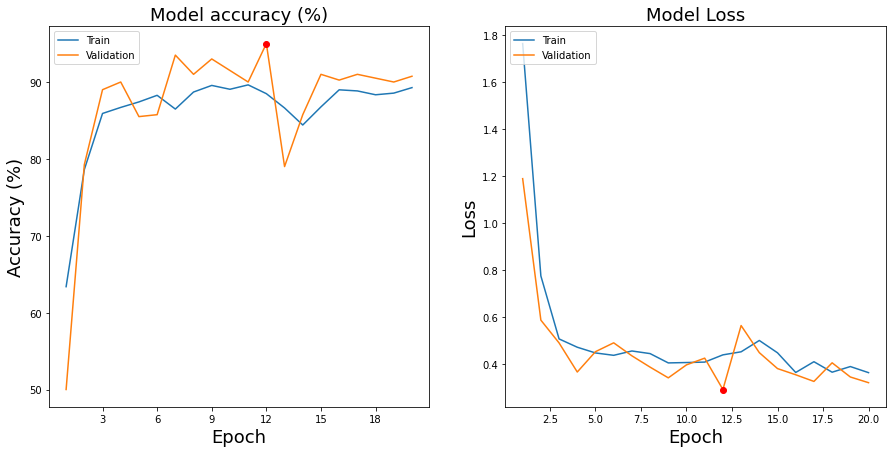

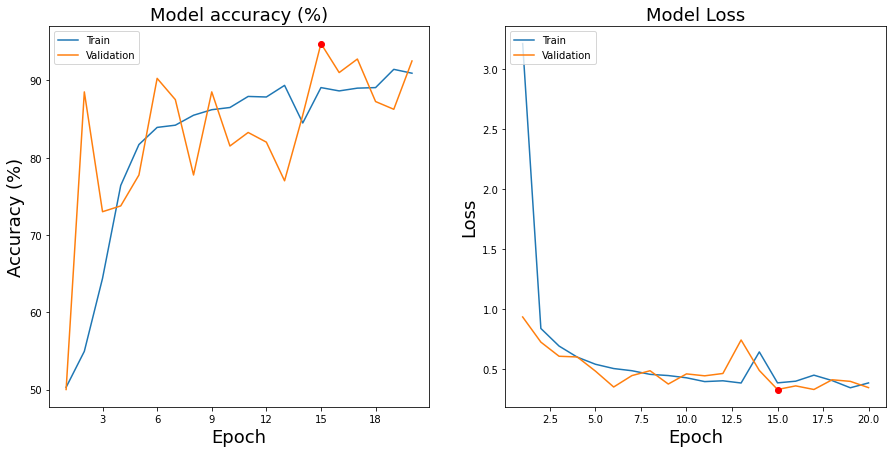

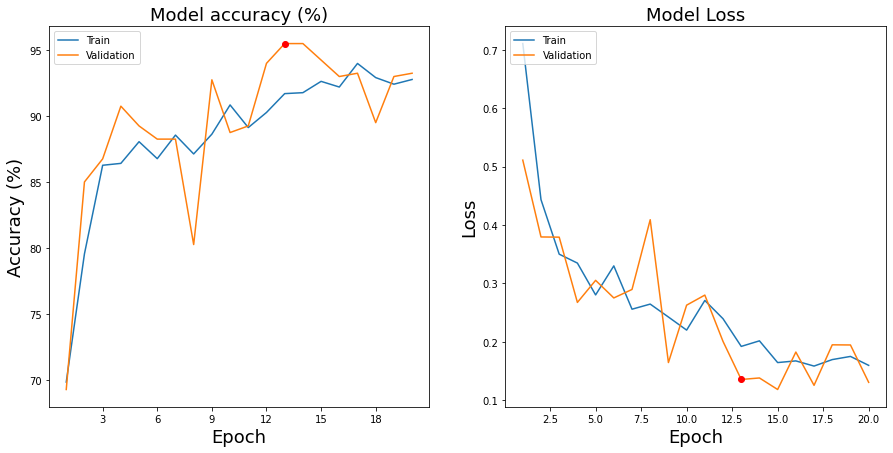

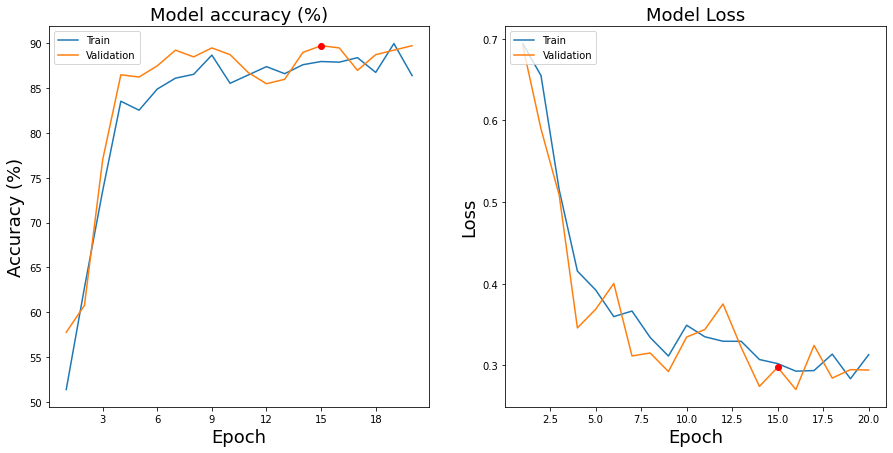

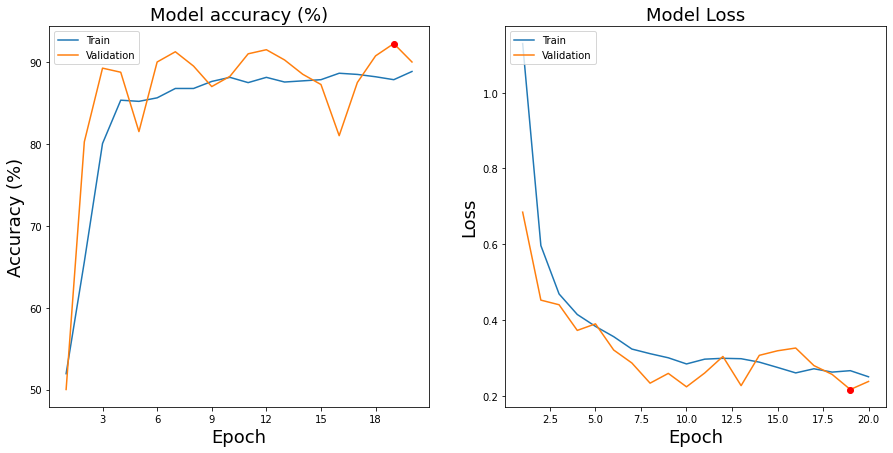

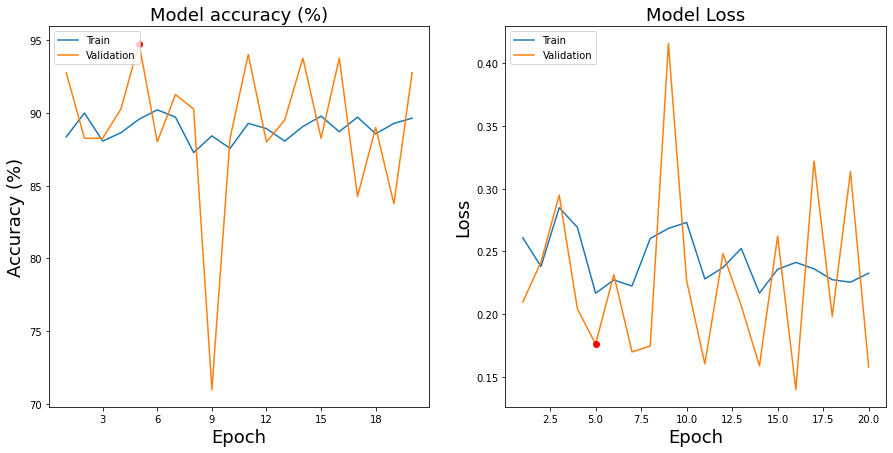

In [79]:
training_graph(history_1)
training_graph(history_2)
training_graph(history_3)
training_graph(history_4)
training_graph(history_5)
training_graph(history_6)

In [119]:
scores(model_3,train_generator,val_generator,test_generator)

44/44 [==============================] - 23s 533ms/step - loss: 0.1538 - accuracy: 0.9278
Train loss    : 0.15378527343273163
Train accuracy: 0.9277539253234863

13/13 [==============================] - 1s 100ms/step - loss: 0.1306 - accuracy: 0.9325
Val loss    : 0.13055352866649628
Val accuracy: 0.9325000047683716

7/7 [==============================] - 1s 95ms/step - loss: 0.1361 - accuracy: 0.9400
Test loss     : 0.13606412708759308
Test accuracy : 0.9399999976158142


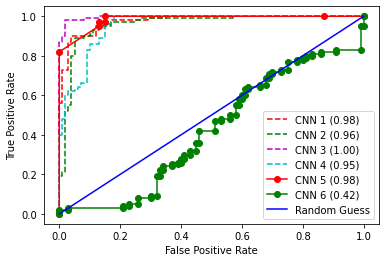

In [128]:
aucs = get_roc([model_1,model_2,model_3,model_4,model_5,model_6],test_generator)

In [130]:
aucs[2]

0.996

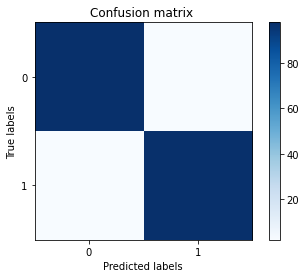

[[98  2]
 [ 2 98]]


In [118]:
conf_matrix(model_3,test_generator,0.3)

In [132]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot

def image_grid(path, grid_h, grid_w):
  image = np.array(load_img(path))
  h, w, _ = image.shape
  grid_dim = (h//grid_h, w//grid_w)
  rem_h, rem_w = h%grid_h, w%grid_w
  image_res = image[rem_h//2:(h-rem_h+rem_h//2),rem_w//2:(w-rem_w+rem_w//2),:]
  
  grid = []
  for i in range(grid_dim[0]):
    row = []
    for j in range(grid_dim[1]):
      row.append(image_res[i*grid_h:(i+1)*grid_h,j*grid_w:(j+1)*grid_w,:])
    grid.append(row)
  return grid, image_res

def predict_grid(model,grid,threshold,class_indices):
  results = []
  for i in range(len(grid)):
    row = []
    for j in range(len(grid[i])):
      image = np.true_divide(grid[i][j],255)
      p_s = model.predict(np.expand_dims(image, axis=0))[0][class_indices["Smoke"]]
      if p_s>threshold:
        est = 1
      else:
        est = 0
      row.append([p_s,est])
    results.append(row)
  return results

def get_coord(results, original):
  new = np.copy(original)
  coord = []
  for i in range(len(results)):
    for j in range(len(results[i])):
      if results[i][j][-1] == 1:
        coord.append((j*341,i*227))
  return coord

def draw_boxes(coord, original, save=False, save_filename = 'file.jpg'):
  height, width, nbands = original.shape
  dpi = 100
  figsize = width / float(dpi), height / float(dpi)

  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])
  ax.axis('off')

  rects = []
  for c in coord:
    rects.append(Rectangle(c,341,227, linewidth = 2, edgecolor='r', facecolor="none"))

  ax.imshow(resized, interpolation='nearest')
  for rect in rects:
    ax.add_patch(rect)

  if save:
    fig.savefig(save_filename, dpi=dpi, transparent=True)
  plt.close()
  return fig

In [239]:
im = 'Forests_Everest_Nepal_Crag_Smoke_539517_3840x2160.jpg' # model_1, 0.97 ---- model_4, 0.89
grid, resized = image_grid(im,227,341)
results = predict_grid(model_4, grid, 0.85,val_generator.class_indices)
coord = get_coord(results,resized)
figure = draw_boxes(coord, resized)

In [ ]:
figure

In [246]:
series = glob('1499*.jpg')
series.sort()
analysed = []
for i in range(len(series)):
  pic = series[i]
  grid, resized = image_grid(pic,227,341)
  results = predict_grid(model_1, grid, 0.95,val_generator.class_indices)
  coord = get_coord(results,resized)
  figure = draw_boxes(coord, resized, save=True, save_filename = f'file_{i}.jpg')

## Transfer Learning

In [ ]:
input_shape_tl = (224,224,3)

In [ ]:
from tensorflow.keras.applications import Xception, VGG16, ResNet50, VGG19

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape = input_shape_tl)
xception = Xception(weights="imagenet", include_top=False, input_shape = input_shape_tl)
resnet = ResNet50(weights="imagenet", include_top=False, input_shape = input_shape_tl)

In [ ]:
vgg16.trainable = False

In [ ]:
input_layer = vgg16.layers[0]
block = vgg16.layers[-1]
flatten = keras.layers.Flatten()(block.output)
dense = keras.layers.Dense(units=64, activation="relu")(flatten)
drop = keras.layers.Dropout(0.5)(dense)
classifier = keras.layers.Dense(units=2, activation="softmax")(dense)
model_tl = keras.Model(inputs=input_layer.output, outputs=classifier, name="vgg16_rebuilt")
model_tl.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
target_size = (224,224)
batch_size = 128

In [ ]:
train_generator_tl = data_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

val_generator_tl = data_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

test_generator_tl = data_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

Found 20100 validated image filenames belonging to 2 classes.
Found 8614 validated image filenames belonging to 2 classes.
Found 6960 validated image filenames belonging to 2 classes.


In [ ]:
history_tl = model_tl.fit(train_generator_tl,
             batch_size = batch_size,
             epochs = 5,
             validation_data = val_generator_tl
             )

Epoch 1/5
79/79 [==============================] - 111s 1s/step - loss: 1.2224e-06 - accuracy: 1.0000 - val_loss: 3.9341 - val_accuracy: 0.7178
Epoch 2/5
79/79 [==============================] - 115s 1s/step - loss: 1.1466e-06 - accuracy: 1.0000 - val_loss: 3.9493 - val_accuracy: 0.7177
Epoch 3/5
79/79 [==============================] - 118s 1s/step - loss: 1.0759e-06 - accuracy: 1.0000 - val_loss: 3.9631 - val_accuracy: 0.7177
Epoch 4/5
79/79 [==============================] - 118s 1s/step - loss: 1.0117e-06 - accuracy: 1.0000 - val_loss: 3.9748 - val_accuracy: 0.7177
Epoch 5/5
79/79 [==============================] - 119s 1s/step - loss: 9.5279e-07 - accuracy: 1.0000 - val_loss: 3.9850 - val_accuracy: 0.7177


In [ ]:
scores_tr = model_tl.evaluate(train_generator_tl)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model_tl.evaluate(val_generator_tl)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model_tl.evaluate(test_generator_tl)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

NameError: ignored

In [ ]:
from sklearn.svm import SVC

In [ ]:
input_layer = vgg16.layers[0]
block = vgg16.layers[-1]
flatten = keras.layers.Flatten()(block.output)
svm = keras.Model(inputs=input_layer.output, outputs=flatten, name="vgg16_rebuilt")
svm.compile()

In [ ]:
features_train = svm.predict(train_generator_tl)
print('yay')
features_val = svm.predict(val_generator_tl)
print('yay')
features_test = svm.predict(test_generator_tl)

yay
yay


In [ ]:
feat_train_df = pd.DataFrame(features_train)
feat_train_df['labels'] = train_generator_tl.labels

feat_val_df = pd.DataFrame(features_val)
feat_val_df['labels'] = val_generator_tl.labels

feat_test_df = pd.DataFrame(features_test)
feat_test_df['labels'] = test_generator_tl.labels

In [ ]:
X_train = feat_train_df.iloc[:,:-1]
Y_train = feat_train_df.iloc[:,-1]

X_val = feat_val_df.iloc[:,:-1]
Y_val = feat_val_df.iloc[:,-1]

X_test = feat_test_df.iloc[:,:-1]
Y_test = feat_test_df.iloc[:,-1]

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,25048,25049,25050,25051,25052,25053,25054,25055,25056,25057,25058,25059,25060,25061,25062,25063,25064,25065,25066,25067,25068,25069,25070,25071,25072,25073,25074,25075,25076,25077,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,0.170598,0.0,0.474863,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.980400,0.0,0.021175,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.589097,0.0,0.000000,0.203922,0.0,0.000000,0.209928,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.154948,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.139516,0.0,0.000000,0.0,0.000000,0.135028,0.0,0.0,0.000000,0.000000,0.478697,0.000000,0.000000,0.570528,1.126843,0.0,1.028536,0.000000,1.526210,0.000000,0.484698,0.374018,0.0,0.00000,0.955743,0.0
1,0.000000,0.0,0.000000,0.0,0.455764,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.662920,0.0,0.534623,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.421979,0.146800,0.0,0.000000,0.000000,0.0,0.000000,0.418633,0.277525,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.260318,0.0,0.000000,0.0,0.000000,0.004435,0.0,0.0,0.000000,0.000000,0.000000,0.121306,0.000000,0.785748,1.266546,0.0,0.305666,0.091766,1.579373,0.000000,0.035112,0.000000,0.0,0.00000,0.569570,0.0
2,0.000000,0.0,0.000000,0.0,0.441899,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.574244,0.0,0.561068,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.014905,0.000000,0.307951,0.0,0.060401,0.000000,0.0,0.179422,0.194730,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.395834,0.0,0.0,0.000000,0.000000,0.0,0.200174,0.0,0.160101,0.000000,0.0,0.000000,0.187828,0.0,0.000000,0.0,0.000000,0.535794,0.0,0.0,0.387830,0.110279,0.000000,0.000000,0.000000,1.011586,0.739471,0.0,1.863735,0.024796,0.467575,0.000000,0.255627,0.359921,0.0,0.00000,0.789765,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.665965,0.0,0.459966,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.716604,0.000000,0.094004,0.0,0.000000,0.000000,0.0,0.000000,0.165549,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.590177,0.0,0.0,0.000000,0.113947,0.0,0.099642,0.0,0.141327,0.109994,0.0,0.000000,0.294028,0.0,0.106456,0.0,0.000000,0.617217,0.0,0.0,0.655021,0.122299,0.000000,0.000000,0.000000,0.851753,0.794628,0.0,1.800528,0.409038,0.453828,0.000000,0.069805,0.431110,0.0,0.00000,0.533375,0.0
4,0.000000,0.0,0.426125,0.0,0.494387,0.0,0.0,0.015623,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154933,0.0,0.494683,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.329135,0.327005,0.0,0.000000,0.649927,0.0,0.000000,0.071019,0.000000,0.054897,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.050570,0.000000,0.0,0.014906,0.542648,0.0,0.000000,0.0,0.264979,0.328953,0.0,0.0,0.000000,0.000000,0.033167,0.000000,0.000000,0.269904,0.874053,0.0,0.516984,0.000000,0.664744,0.000000,0.309509,0.000000,0.0,0.00000,0.502688,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20095,0.028288,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.064507,0.0,0.0,0.574259,0.0,0.559202,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.234869,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.166540,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.645766,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.664882,0.0,0.000000,0.0,0.000000,0.308722,0.0,0.0,0.163170,0.036957,0.208717,0.000000,0.000000,0.453836,1.321143,0.0,1.659078,0.000000,0.938669,0.000000,0.454096,0.423521,0.0,0.00000,0.797178,0.0
20096,0.006461,0.0,0.709478,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0

In [ ]:
model_ml = SVC(C=0.8)
model_ml.fit(X_train,Y_train)

In [ ]:
model_ml.score(X_train, Y_train)

In [ ]:
model_ml.score(X_test, Y_test)

## Heat Map

In [ ]:
keras.optimizers.Adam(1e-3)